[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jmourabarbosa/lowrank_tutorial/blob/main/tutorial1.ipynb)

### uncomment this if running in google colab

In [114]:
!git clone https://github.com/jmourabarbosa/lowrank_tutorial/
import sys
sys.path.append('lowrank_tutorial/')

In [110]:
import numpy as np
import matplotlib.pylab as plt
import lowrank_helpers as lrh
import imp
imp.reload(lrh)

<module 'lowrank_helpers' from '/Users/srdjan/Dropbox/Teaching/2025 MBL/Tutorial/revised/lowrank_helpers.py'>


# Introduction to low-rank recurrent neural networks

### Goals of this tutorial:

* Introduction to recurrent neural networks (RNN)
* basics of low-rank RNN theory (linear)
* basics of low-rank RNN theory (non-linear)

Note: This tutorial is heavily based on the paper and code provided in [(Mastrogiuseppe & Ostojic, 2019)](https://github.com/fmastrogiuseppe/LowRank). For more advance concepts, please refer to that paper.

We consider a recurrent neural network (RNN) of $N$ neurons, where each neuron has a time-dependent membrane voltage $x_i(t)$ and produces a firing rate through the transfer function $\phi(x_i(t))$.

Here, we will use either $\phi(x) = x$ or $\phi = tanh(x)$. 

Neurons in an RNN are recurrently connected. The strength of the synapse from neuron $j$ to neuron $i$ is denoted as $J_{ij}$. 

For the purpose if this tutorial, the recurrent connectivity will be rank 1: $J_{ij} = \frac{1}{N}\sum_{j=1}^N m_i n_j$.

In adition to recurrent inputs, each neuron might be driven by external inputs. For simplicity, we will consider the case of a scalar input $u(t)$ that is fed to  neuron $i$ through the weight  $I_i$.

Altogether, the network dynamics are given by 

$$\dot{x_i} = -x_i + \frac{1}{N}\sum_{j=1}^N m_i n_j\phi(x_j) + u(t)I_i$$

Assumming that $\bf m \perp I$, the activity of this network will be confined to a 2D plane defined by the vectors $\bf m$ and $\bf I$:

$$x_i(t) = \kappa(t) m_i + v(t)I_i \; \; \; \small (1)$$



# 1. Linear low-rank RNN

***Exercise 1.1.***

An important insight of the low-rank RNN theory is that the alignment between the vectors definning the RNN (in this case $\bf m,n,I$) fully determine the dynamics performed by the network.

<p align="center">
<img src="https://github.com/jmourabarbosa/lowrank_tutorial/blob/main/figures/mastrogiuseppe.png?raw=1" alt="drawing" width="600"/>
</p>


We will gradually develop the intuition (and theory) for why this is the case.

* Which scenario are we below for the vectors  m, n, IA?

* How about IB?

In [167]:
m,n,IA,IB = lrh.m, lrh.n, lrh.IA, lrh.IB

N = 1000

lrh.overlaps[0,1] = lrh.overlaps[1,0] = 0 #1.2
lrh.overlaps[1,2] = lrh.overlaps[2,1] = 1.2

m,n,IA,IB  = np.random.multivariate_normal([0,0,0,0], lrh.overlaps, size=N).T

m = m - (m @ n) * n / (n @ n)
IA = IA - (IA @ m) * m / (m @ m)
IB = IB - (IB @ m) * m / (m @ m)
IB = IB - (IB @ n) * n / (n @ n)

N=len(m)

print((m @ n)/N)


8.526512829121202e-17


***Exercise 1.2***

* Use the following code to run a *linear* rank 1 network with $J = \frac{1}{N}mn^T$ that recieves inputs from IA

* Plot the currents of some neurons.

* Plot the mean activity.

In [168]:
def phi(x):
  # toggle between linear and non-linear
  return np.tanh(x)
  #return x

dt = 0.1

time = np.linspace(0,30,int(30//dt))

J = np.outer(m,n) / N
u = np.zeros_like(time)

# inputs are on during this period, off otherwise
u[50:150] = 1

# two trials, one for each input
x = np.zeros([2,N])
X = np.zeros((2,len(time),N))

for ti, _ in enumerate(time):
  x[0] = x[0] + dt*(-x[0] + J @ phi(x[0]) + IA*u[ti])
  x[1] = x[1] + dt*(-x[1] + J @ phi(x[1]) + IB*u[ti])
  X[:,ti,:] = x



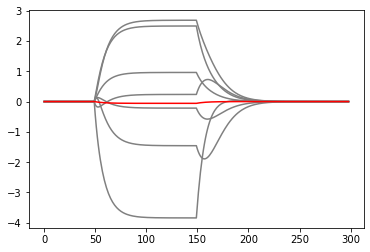

In [169]:
plt.plot(X[0,:,:7],"gray")
plt.plot(np.mean(X[1,:],axis=1),"r")

***Exercise 1.3***

Instead of looking at each neuron individually, it is more informative to do dimensionality reduction.

One way of doing this is using PCA. You can try, but given our theory we know that the actvity of x is going to be in m-I plane (equation 1, above).

* Check this fact by projecting the activity on m and I, separatedly, then together.

* Can you guess how many PCs would PCA return?

([], [])

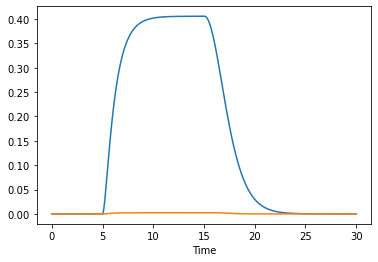

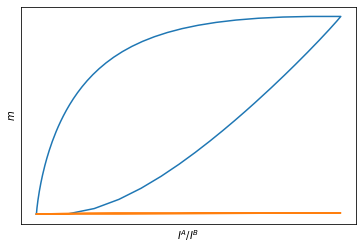

In [170]:
plt.plot(time,X[0] @ m / np.linalg.norm(m)**2)
plt.plot(time,X[1] @ m / np.linalg.norm(m)**2)
plt.xlabel("Time")

plt.figure()
plt.plot(X[0] @ IA / np.linalg.norm(IA)**2,X[0] @ m / np.linalg.norm(m)**2)
plt.plot(X[1] @ IB / np.linalg.norm(IB)**2,X[1] @ m / np.linalg.norm(m)**2)
plt.xlabel('$I^A / I^B$')
plt.ylabel('$m$')
plt.xticks([])
plt.yticks([])

***Exercise 1.5***

* Do the same as above, but make the network receive inputs through IB.
* Plot the the activity of some neurons
* Plot the mean activity
* Plot the m-I plane
* What would be the output of PCA, for this case?

# 2. Solving for kappa (Linear case)

Since $x_i = \kappa m_i + v I_i$,
we can get  an equation for $\dot v$ by projecting $\dot \bf x$ on $\frac{{\bf I}}{|{\bf I}|^2}$, and an equation for $\dot \kappa$ by projecting $\dot \bf x$ on $\frac{{\bf m}}{|{\bf m}|^2}$:

$$ \dot v = -v + u $$
$$ \dot \kappa = -k + \frac{1}{N}\sum_{j=1}^N n_j\phi(\kappa_j + v(t) I_j) \; \; \; \small (2)$$


In the case where $\phi(x) = x$ and using simple linear algebra we can simply this futher:

$$ \dot \kappa = -k + \sigma_{nm}\kappa + \sigma_{nI}v \; \; \; \small (3)$$
$$ \dot v = -v + u$$


with $\sigma_{ab} = \frac{a^Tb}{N}$.




***Exercise 2.1.***

* Calculate $\sigma_{mn}$ and $\sigma_{nI}$ (for both inputs)
* Use these overlaps to integrate $\dot \kappa$ and $\dot v$ (tip: reuse the above code to integrate $\dot x$)
* plot on the same plot $\dot \kappa$ and $\dot x$ using $\phi(x) = x$ and $\phi(x) = tanh(x)$.
* Do they match?

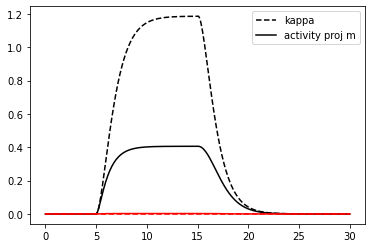

In [171]:
# two trials, one for each input
kappa = [0,0]
v = [0,0]
K = np.zeros((2,len(time)))


for ti in range(len(time)):
    #first input
    s_sigma_mn, s_sigma_nI = np.dot(m,n) / len(m), np.dot(n,IA) / len(m)
    kappa_rec = s_sigma_mn * kappa[0] + s_sigma_nI* v[0]
    v[0] = v[0] + dt*(-v[0] + u[ti])
    kappa[0] = kappa[0] + dt*(-kappa[0] + kappa_rec)
    K[0,ti] = kappa[0]

    # second input
    s_sigma_mn, s_sigma_nI = np.dot(m,n) / len(m), np.dot(n,IB) / len(m)    
    kappa_rec = s_sigma_mn * kappa[1] + s_sigma_nI* v[1]
    v[1] = v[1] + dt*(-v[1] +  u[ti])
    kappa[1] = kappa[1] + dt*(-kappa[1] + kappa_rec)
    K[1,ti] = kappa[1]


plt.plot(time,K[0],'k--',label='kappa')
plt.plot(time,X[0] @ m / np.linalg.norm(m)**2,'k',label='activity proj m')

plt.plot(time,K[1],'r--')
plt.plot(time,X[1] @ m / np.linalg.norm(m)**2,'r')

plt.legend()

# 3. non-linear low-rank RNN ##

***Exercise 3***

* Use the code provided above to run a *non-linear* network with the same m, n, IA, IB vectors, but with tanh as the transfer function.

* Look at the activations and projections on m and I.

* What changed?

* Generate new set of network vectors in which the overlap between m and n is > 0 (the third case in 1.1)

* how bad is the linear approximation? Why?

# 4. Solving for kappa (non-linear case)

Now that we checked our intutions with the linear case, lets solve $\dot \kappa$ also for the non-linear case. 

As in the linear case, we can get  an equation for $\dot v$ by projecting $\dot \bf x$ on $\frac{{\bf I}}{|{\bf I}|^2}$, and an equation for $\dot \kappa$ by projecting $\dot \bf x$ on $\frac{{\bf m}}{|{\bf m}|^2}$:

$$ \dot v = -v + u $$
$$ \dot \kappa = -k + \frac{1}{N}\sum_{j=1}^N n_j\phi(\kappa_j + v(t) I_j) \; \; \; \small (2)$$

Note that these two-dimensional equations are an exact reduction of the full $N$-dimensional network dynamics. The solution of the two dimensional equation should precisely match the dynamics obtained by running the $N$-dimensional network dynamics, and projecting onto $\frac{{\bf I}}{|{\bf I}|^2}$ and $\frac{{\bf m}}{|{\bf m}|^2}$.




***Exercise 3.1***
* reuse the code you used above for integreating $\dot x$ and $\dot \kappa$ for the linear case to integrate equation 2.
* compare what you got with the non-linear RNN.

In [172]:

# two trials, one for each input
k_ = np.zeros([2])
K_ = np.zeros((2,len(time)))
v = np.zeros([2])
V_ = np.zeros((2,len(time)))

for ti, _ in enumerate(time):
  # first input
  v_temp=v[0]
  v[0] = v[0] + dt*(-v[0] + u[ti])
  k_[0] = k_[0] + dt*(-k_[0] + 1/N*n.T @ phi(k_[0]*m + v_temp*IA))

  # second input
  v_temp=v[1]
  v[1] = v[1] + dt*(-v[1] + u[ti])
  k_[1] = k_[1] + dt*(-k_[1] + 1/N*n.T @ phi(k_[1]*m + v_temp*IB))
  K_[:,ti] = k_
  V_[:,ti] = v



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.011421810590055086
0.01142181059005509


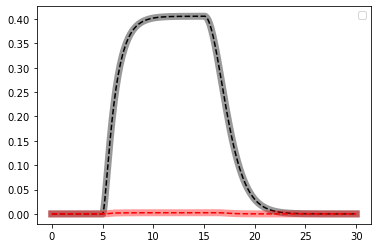

In [173]:



plt.plot(time,X[0] @ m / np.linalg.norm(m)**2,"k--")
plt.plot(time,K_[0],"k-", lw=7, alpha=0.4)

plt.plot(time,X[1] @ m / np.linalg.norm(m)**2,'r--')
plt.plot(time,K_[1],'r-', lw=7, alpha=0.4)

plt.legend()
print(K_[0][51])
print(X[0][51] @ m / np.linalg.norm(m)**2)


#

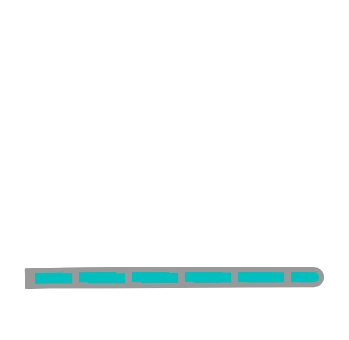

In [178]:
#2D plot from lecture slides
plt.figure(figsize=(6, 6))
plt.plot(V_[1], K_[1], "k-", lw=20, alpha=0.4)
plt.plot(X[1] @ IB / np.linalg.norm(IB)**2,X[1] @ m / np.linalg.norm(m)**2, "c--", lw=10)

#plt.plot(X[1] @ IB / np.linalg.norm(IB)**2,X[1] @ m / np.linalg.norm(m)**2)

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,0.5)

plt.axis('off')
plt.savefig("resp0.png")

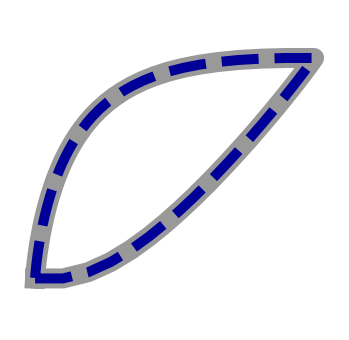

In [175]:
#2D plot from lecture slides
plt.figure(figsize=(6, 6))
plt.plot(X[0] @ IA / np.linalg.norm(IA)**2,X[0] @ m / np.linalg.norm(m)**2, "b--", lw=10)
plt.plot(V_[0], K_[0], "k-", lw=20, alpha=0.4)
#plt.plot(X[1] @ IB / np.linalg.norm(IB)**2,X[1] @ m / np.linalg.norm(m)**2)

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,0.5)
plt.axis('off')
plt.savefig("resp1.png")

(bonus) ***Exercise 3.2*** Using the fact that the vectors $\bf m, n$ and $I$ are generated from a joint Gaussian distribution, taking the limit $N \rightarrow \infty$, we can express the low-dimensional in terms of effective connectivities $\tilde{\sigma}$ obtained directly from the overlaps ${\sigma}$:


$$ \dot \kappa = -k + \tilde{\sigma}_{nm}\kappa + \tilde{\sigma}_{nI}v \; \; \; \small (3)$$
$$ \dot v = -v + u$$


with:

$\tilde{\sigma}_{ab} = a^Tb/N <\phi'(0,\Delta)>$ 

$\Delta  =  \kappa^2 \sigma_{m}^2 + v^2\sigma_{I}^2$

The derivation of this can be found in  (Dubreuil, Valente et al, 2019) and (Beiran et al 2020). 

Intuitively, the dynamics of $\kappa$ depend no only on the fixed connectivity (i.e. overlaps), but also on the average gain (i.e. $<\phi'>$) that implicitly depends on the network state.

* Using phi_prime function below, integrate $\dot \kappa$ only using the overlaps.
* The match between the network (projected on $m$) and $\kappa$ might be pretty good but probably not perfect. 


In [58]:
gaussian_norm = (1/np.sqrt(np.pi))
gauss_points, gauss_weights = np.polynomial.hermite.hermgauss(200)
gauss_points = gauss_points*np.sqrt(2)

def phi (mu, delta0):
    integrand = np.tanh(mu+np.sqrt(delta0)*gauss_points)
    return gaussian_norm * np.dot (integrand,gauss_weights)

def phi_prime (mu, delta0):
    integrand = 1 - (np.tanh(mu+np.sqrt(delta0)*gauss_points))**2
    return gaussian_norm * np.dot (integrand,gauss_weights)

def calc_effective_conn(kappa, kappa_I,I,n,overlaps):


  sigma_II = np.dot(I,I)/len(I)
  sigma_nI = np.dot(n,I)/len(I)

  sigma_mm = overlaps[0,0]
  sigma_mn = overlaps[0,1]

  delta =sigma_mm * kappa**2 + sigma_II * kappa_I**2

  s_sigma_mn=sigma_mn * phi_prime(0,delta)
  s_sigma_nI=sigma_nI * phi_prime(0,delta)

  return s_sigma_mn, s_sigma_nI

# two trials, one for each input
kappa = [0,0]
kappa_I = [0,0]
K = np.zeros((2,len(time)))

for ti in range(len(time)):

    # first input
    s_sigma_mn, s_sigma_nI = calc_effective_conn(kappa[0], kappa_I[0],IA,n,lrh.overlaps)
    kappa_rec = s_sigma_mn * kappa[0]+s_sigma_nI *kappa_I[0]
    kappa_I[0] = kappa_I[0] + dt*(-kappa_I[0] +  u[ti])
    kappa[0] = kappa[0] + dt*(-kappa[0] + kappa_rec)

    # second input
    s_sigma_mn, s_sigma_nI = calc_effective_conn(kappa[1], kappa_I[1],IB,n,lrh.overlaps)
    kappa_rec = s_sigma_mn * kappa[1]+s_sigma_nI *kappa_I[1]
    kappa_I[1] = kappa_I[1] + dt*(-kappa_I[1] +  u[ti])
    kappa[1] = kappa[1] + dt*(-kappa[1] + kappa_rec)

    K[:,ti] = kappa


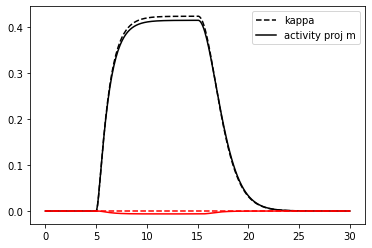

In [59]:
plt.plot(time,K[0],'k--',label='kappa')
plt.plot(time,X[0] @ m / np.linalg.norm(m)**2,'k',label='activity proj m')

plt.plot(time,K[1],'r--')
plt.plot(time,X[1] @ m / np.linalg.norm(m)**2,'r')

plt.legend()